# Recurrent Neural Networks


Recurrent Neural Networks are a particular type of neural network where some of the connections can go "backwards"
(there are loops in the structure of the network). Their structure is such they are still differentiable, so we can still
use gradient descend to train them. Their usage is not limited to time series (such as business trends  or video analysis) but also handwriting recognition
and text analysis.
 
In this lab we'll try a variant called LSTM that are much better at 'remembering'long term dependencies (see
`vanishing gradient` in the resources below)

#### External resources:
* [Conincise explanation of RNNs and LSTMs](https://towardsdatascience.com/understanding-lstm-and-its-quick-implementation-in-keras-for-sentiment-analysis-af410fd85b47)
(most of the keras code comes from here)
* [Embedding explanation](https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/)



In [29]:
# Loading dependencies by running the code block below.
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from keras import metrics
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras import backend as K #  solves compatibility errors

from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_style("dark", {
        "axes.labelcolor": ".9",
        'axes.facecolor': 'white',
        'xtick.color': '.9',
        'ytick.color': '.9',
    })

%matplotlib inline



In [64]:
# loading the dataset
data = pd.read_csv('../data/wikipedia.csv')
# we'll only work on a small part of the dataset, for convenience. Accuracy will be bad
data = data.sample(frac=0.1, random_state=1)
data


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
24915,41e65f43c180838e,"YOU ARE A FAT, GEEKY PRICK WHO HAS NOTHING TO ...",1,1,1,0,1,0
75819,cade9e425d75948e,Agent X2: Basically thanks - with a 'little' m...,0,0,0,0,0,0
53891,8ff87747403ed2e6,Why are my posts being deleted? \r\n\r\nI have...,0,0,0,0,0,0
154159,a95604c7a938abb3,"""\r\n\r\n Controlled Demolitions and Common Se...",0,0,0,0,0,0
13040,2288910537399728,I do not understand your reply. //Blaxthos ( ...,0,0,0,0,0,0
123190,9309014f225e9975,Is this the bizarro world? Removing content is...,0,0,0,0,0,0
33626,59a295885d985ef1,"Well, WP:RS says that articles should use reli...",0,0,0,0,0,0
1150,031c15507901e54a,Oh hear me go someone removes all my pages i g...,0,0,0,0,0,0
48633,820b548b9acc1ee6,can't believe this article was deleted\r\nI'm ...,0,0,0,0,0,0
42817,723d53b4406dc45a,"""\r\n\r\n Comments on GamerGate Workshop page ...",0,0,0,0,0,0


In [73]:
# explore the dataset
sns.countplot(x=['toxic', 'severe_toxic'], data=data)
plt.show()


TypeError: Argument 'obj' has incorrect type (expected list, got DataFrame)

## Preprocessing: dictionary and padding
To make it easier to work with text sequences, we are gonna take two preliminary steps:
* convert words into numbers   
* transform arbitrary-size comments into fixed size sequences

Keras has an helpful API called `Tokenizer` that can handle those steps and the hidden
nuisances and headaches for us. The most important decisions to take are:
* how big my dictionary has to be? (too big and the network will be enormous, too small and
the classification will be imprecise and biased)
* which special characters determine a split and which ones not?
* case-sensitive?

Some problems are there, but they don't have a definitive solution, like synonyms ('metalearning' vs 'meta-learning' vs
'meta learning' and so on). In most cases, it depends on the problem. Special characters and case sensitivity could be
meaningless while analyzing an academic paper, but they are probably very important in detecting toxic comments.
('you are wrong' vs 'YOU ARE WRONG!!!!!!1!!)  
    


In [66]:
# create dictionary (using keras' Tokenizer API)
tokenizer = Tokenizer(nb_words=2500, lower=True, split=' ')
tokenizer.fit_on_texts(data['comment_text'].values)
print(tokenizer.word_index)


c:\users\chris\appdata\local\programs\python\python36\lib\site-packages\keras_preprocessing\text.py:177: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


{'the': 1, '\r': 2, 'to': 3, 'of': 4, 'and': 5, 'a': 6, 'you': 7, 'i': 8, 'is': 9, 'that': 10, 'in': 11, 'it': 12, 'for': 13, 'this': 14, 'not': 15, 'on': 16, 'be': 17, 'as': 18, 'are': 19, 'have': 20, 'your': 21, 'with': 22, 'if': 23, 'article': 24, 'was': 25, 'or': 26, 'but': 27, 'my': 28, 'wikipedia': 29, 'an': 30, 'page': 31, 'at': 32, 'by': 33, 'from': 34, 'do': 35, 'about': 36, 'so': 37, 'talk': 38, 'me': 39, 'can': 40, 'what': 41, 'there': 42, 'all': 43, 'has': 44, 'would': 45, 'one': 46, 'please': 47, 'no': 48, 'will': 49, 'just': 50, 'he': 51, 'like': 52, 'they': 53, 'been': 54, "don't": 55, 'any': 56, 'which': 57, 'we': 58, 'more': 59, 'some': 60, 'should': 61, 'other': 62, 'see': 63, 'who': 64, 'here': 65, 'also': 66, 'his': 67, 'think': 68, 'because': 69, 'know': 70, 'how': 71, 'edit': 72, "it's": 73, "i'm": 74, 'use': 75, 'people': 76, 'why': 77, 'out': 78, 'only': 79, 'up': 80, 'when': 81, 'articles': 82, 'am': 83, 'time': 84, 'then': 85, 'may': 86, 'were': 87, 'them': 88

In [67]:

X = tokenizer.texts_to_sequences(data['comment_text'].values)
X = pad_sequences(X, padding='post')
X


array([[   7,   19,    6, ...,    0,    0,    0],
       [1109,   96,   22, ...,    0,    0,    0],
       [  77,   19,   28, ...,    0,    0,    0],
       ...,
       [ 963,  600,    2, ...,    0,    0,    0],
       [ 507,    3,    2, ...,    0,    0,    0],
       [  11,    1,  157, ...,    0,    0,    0]])

## Custom metrics
Keras has several metrics available out of the box, but it's possible to define custom ones. This is very useful
in several cases. In our case, our database is skewed and we are most interested in true positive and true negative,
so we would like to have precision and recall available

In [68]:
"""

For specs see https://keras.io/metrics/
"""
def precision(y_true, y_pred):
    """Precision metric.

    Only computes a batch-wise average of precision.

    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    prec = true_positives / (predicted_positives + K.epsilon())
    return prec

def recall(y_true, y_pred):
    """Recall metric.

    Only computes a batch-wise average of recall.

    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    rec = true_positives / (possible_positives + K.epsilon())
    return rec


## Defining the model
Keras allows for many different levels of detail. We'll deal only with the higher level one, where keras builds the entire
recurrent layer and asks only for its hyperparameters.

A different option is to define a single (or multiple) type of recurrent cell and connect them together manually(search
`MinimalRNNCell` [here](https://keras.io/layers/recurrent/).

The lowest level is to define the computation graph directly into [TensorFlow](https://www.tensorflow.org/tutorials/sequences/recurrent),
but requires a very good understanding of both the theory of your RNN and of the TensorFlow architecture. It has the potential
of being very powerful and efficient, but it could end up be buggy and slower than the default implementations.  


In [69]:
embed_dim = 128
lstm_out = 200
batch_size = 32

model = Sequential()
model.add(Embedding(2500, embed_dim,input_length = X.shape[1], dropout = 0.2))
model.add(LSTM(lstm_out, dropout_U = 0.2, dropout_W = 0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = [metrics.binary_accuracy, precision, recall])
print(model.summary())



c:\users\chris\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:6: UserWarning: The `dropout` argument is no longer support in `Embedding`. You can apply a `keras.layers.SpatialDropout1D` layer right after the `Embedding` layer to get the same behavior.
  
c:\users\chris\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(200, dropout=0.2, recurrent_dropout=0.2)`
  import sys


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 1250, 128)         320000    
_________________________________________________________________
lstm_9 (LSTM)                (None, 200)               263200    
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 402       
Total params: 583,602
Trainable params: 583,602
Non-trainable params: 0
_________________________________________________________________
None


## Split the dataset into train and validation


In [70]:
#  convert categorical variables into one-hot encoding
Y = pd.get_dummies(data['toxic']).values
# splitting with sklearn instead of pandas so we get the data in a format ready to be fed to keras 
X_train, X_valid, Y_train, Y_valid = train_test_split(X,Y, test_size = 0.20, random_state = 36)


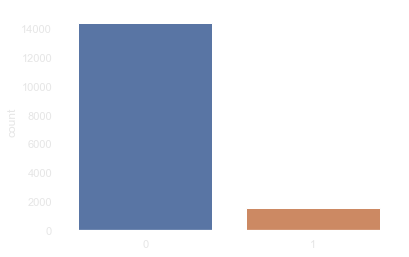

In [71]:
sns.countplot(x=[y[1] for y in Y])
plt.show()


In [72]:
#Here we train the Network.

results = model.fit(
    X_train,
    Y_train,
    batch_size =batch_size,
    epochs = 10,
    verbose = 2,
    validation_data=(X_valid, Y_valid)
)
results.history


Train on 12765 samples, validate on 3192 samples
Epoch 1/10
 - 669s - loss: 0.3245 - binary_accuracy: 0.9020 - precision: 0.9020 - recall: 0.9020 - val_loss: 0.3350 - val_binary_accuracy: 0.8957 - val_precision: 0.8957 - val_recall: 0.8957
Epoch 2/10
 - 729s - loss: 0.3198 - binary_accuracy: 0.9033 - precision: 0.9033 - recall: 0.9033 - val_loss: 0.3347 - val_binary_accuracy: 0.8957 - val_precision: 0.8957 - val_recall: 0.8957
Epoch 3/10
 - 700s - loss: 0.3196 - binary_accuracy: 0.9033 - precision: 0.9033 - recall: 0.9033 - val_loss: 0.3436 - val_binary_accuracy: 0.8957 - val_precision: 0.8957 - val_recall: 0.8957
Epoch 4/10
 - 724s - loss: 0.3189 - binary_accuracy: 0.9033 - precision: 0.9033 - recall: 0.9033 - val_loss: 0.3371 - val_binary_accuracy: 0.8957 - val_precision: 0.8957 - val_recall: 0.8957
Epoch 5/10
 - 723s - loss: 0.3189 - binary_accuracy: 0.9033 - precision: 0.9033 - recall: 0.9033 - val_loss: 0.3359 - val_binary_accuracy: 0.8957 - val_precision: 0.8957 - val_recall: 0.8

{'binary_accuracy': [0.9019976497910511,
  0.9032510771314349,
  0.9033294164242578,
  0.9033294163308702,
  0.903329416340209,
  0.9033294163822334,
  0.9033294163822334,
  0.903329416340209,
  0.9033294164335965,
  0.9033294163822334],
 'loss': [0.3244705535386807,
  0.3198081296726717,
  0.3195732435291065,
  0.3189114102290464,
  0.31894282919492994,
  0.31892613259615077,
  0.3190959068335508,
  0.3187495659833976,
  0.31876493825008484,
  0.319078698529013],
 'precision': [0.9019976497910511,
  0.9032510771314349,
  0.9033294164242578,
  0.9033294163308702,
  0.903329416340209,
  0.9033294163822334,
  0.9033294163822334,
  0.903329416340209,
  0.9033294164335965,
  0.9033294163822334],
 'recall': [0.9019976497910511,
  0.9032510771314349,
  0.9033294164242578,
  0.9033294163308702,
  0.903329416340209,
  0.9033294163822334,
  0.9033294163822334,
  0.903329416340209,
  0.9033294164335965,
  0.9033294163822334],
 'val_binary_accuracy': [0.8956766918787084,
  0.8956766918787084,
  0

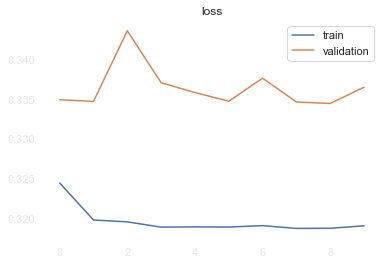

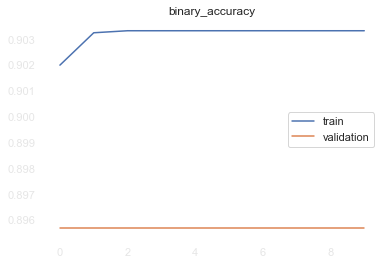

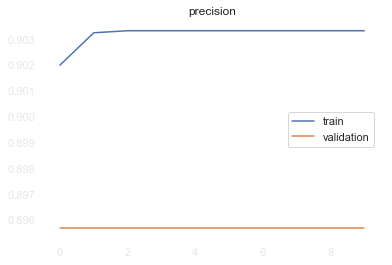

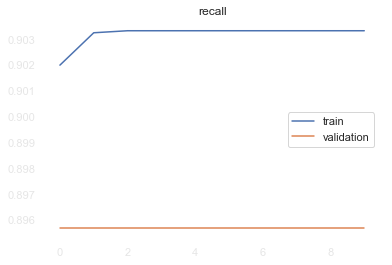

In [76]:
# plot all our metrics
for metric in results.history.keys():
    if 'val_' not in metric:
        sns.lineplot(results.epoch, results.history[metric])
        sns.lineplot(results.epoch, results.history[f'val_{metric}']) \
            .set_title(metric)
        plt.legend(['train', 'validation'])
        plt.show()


## Forecasting


In [ ]:
# date-time parsing function for loading the dataset
def parser(x):
    return datetime.strptime('190' + x, '%Y-%m')


# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag + 1)]
    columns.append(df)
    df = concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df


# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)


# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]


# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled


# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]


# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    return model


# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0, 0]


In [ ]:
# load dataset
series = read_csv('../data/shampoo.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)


In [ ]:
# transform data to be stationary
raw_values = series.values
diff_values = difference(raw_values, 1)


In [ ]:
# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values


In [ ]:
# split data into train and test-sets
train, test = supervised_values[0:-12], supervised_values[-12:]


In [ ]:
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)


In [ ]:
# fit the model
lstm_model = fit_lstm(train_scaled, 1, 3000, 4)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)


In [ ]:
# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
    # make one-step forecast
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = forecast_lstm(lstm_model, 1, X)
    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    # invert differencing
    yhat = inverse_difference(raw_values, yhat, len(test_scaled) + 1 - i)
    # store forecast
    predictions.append(yhat)
    expected = raw_values[len(train) + i + 1]
    print('Month=%d, Predicted=%f, Expected=%f' % (i + 1, yhat, expected))


In [ ]:
# report performance
rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
print('Test RMSE: %.3f' % rmse)
# line plot of observed vs predicted
plt.plot(raw_values[-12:], label='expected')
plt.plot(predictions, label='predictions')
plt.legend()
plt.show()


## Tricks
* RNN training is very resource intensive. Always test your model on [toy problems](https://machinelearningmastery.com/sequence-prediction-problems-learning-lstm-recurrent-neural-networks/)
 first 
* Learn the `Embedding` layer alone and save it [link](https://machinelearningmastery.com/save-load-keras-deep-learning-models/)
so that in the future  only  the LSTM weights needs to be learnt (it's also possible to use pre trained embeddings)